In [1]:
from qbm_utils import *
from qiskit.quantum_info import Pauli
#from qiskit.extensions import UGate, RZZGate
from qiskit.circuit.library import RZZGate, UGate, MCXGate

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Quantum enhanced MCMC implementation
Aim is to implement the circuit for implementing quantum enhanced MCMC

In [3]:
import qiskit

{'qiskit-terra': '0.21.2', 'qiskit-aer': '0.10.4', 'qiskit-ignis': '0.6.0', 'qiskit-ibmq-provider': '0.19.2', 'qiskit': '0.37.2', 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}

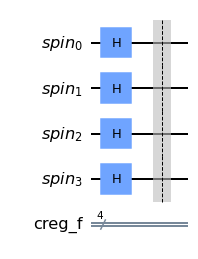

In [54]:
## put n_spins even always
n_spins = 4

## construct problem Hamiltonian ##
shape_of_J=(n_spins,n_spins)
J =  np.random.randn(n_spins,n_spins)#np.random.uniform(low= -1, high= 1, size= (n_spins, n_spins) )
J = 0.5 * (J + J.transpose() )
h = np.random.randn(n_spins)#np.random.uniform(low= -1, high = 1, size= (n_spins))
model = IsingEnergyFunction(J, h)

alpha = np.sqrt(n_spins) / np.sqrt( sum([J[i][j]**2 for i in range(n_spins) for j in range(i)]) + sum([h[j]**2 for j in range(n_spins)])  )


# initial case : later I need to create a function for it!
spins = QuantumRegister(n_spins, name= 'spin')
creg_final = ClassicalRegister(n_spins, name= 'creg_f')
qc = QuantumCircuit(spins, creg_final)
qc.h(spins)
qc.barrier()
qc.draw("mpl")

In [82]:
# quantum procedure to make transitions from s to s'
def run_qc_quantum_step(qc_initialised_to_s:QuantumCircuit, alpha,num_trotter_steps=10, time=0.8)->str:

    '''     
    Takes in a qc initialized to some state "s". After performing unitary evolution U=exp(-iHt)
    , circuit is measured once and returns the state " s' " so obtained.

    Args:
    qc_initialised_to_s
    alpha:
    num_trotter_steps: (default 10)
    time: For how long you want to evolve.
    '''
    for _ in range(num_trotter_steps):
        append_evolution(qc_initialised_to_s, h, J ,gamma=np.random.random(), alpha=alpha, time=time)
    append_evolution(qc_initialised_to_s, h, J , gamma=0.1, alpha=alpha, time=time, is_terminal_step=True)
    
    # draw the ckt
    #print(qc_initialised_to_s.draw())

    # run the circuit
    creg_final=ClassicalRegister(n_spins, name= 'creg_f')
    num_shots=1
    qc_initialised_to_s.measure(qc.qubits, creg_final)
    state_obtained_dict=execute(qc, shots= num_shots, backend= qsm).result().get_counts()
    state_obtained=list(state_obtained_dict.keys())[0]#since there is only one element
    return state_obtained

### Run the quantum step to carry out transition from s to $s^{'}$

In [56]:
num_trotter_steps=5
state_obtained=run_qc_quantum_step(qc, alpha,num_trotter_steps, time=0.8)
print(state_obtained)

          ┌───┐ ░ ┌─────┐                               ░ ┌─────┐»
  spin_0: ┤ H ├─░─┤ h_0 ├──■────────────────────────────░─┤ h_0 ├»
          ├───┤ ░ ├─────┤  │ZZ(0.33438)                 ░ ├─────┤»
  spin_1: ┤ H ├─░─┤ h_1 ├──■─────────────■──────────────░─┤ h_1 ├»
          ├───┤ ░ ├─────┤                │ZZ(-0.21075)  ░ ├─────┤»
  spin_2: ┤ H ├─░─┤ h_2 ├─■──────────────■──────────────░─┤ h_2 ├»
          ├───┤ ░ ├─────┤ │ZZ(-0.91064)                 ░ ├─────┤»
  spin_3: ┤ H ├─░─┤ h_3 ├─■─────────────────────────────░─┤ h_3 ├»
          └───┘ ░ └─────┘                               ░ └─────┘»
creg_f: 4/═══════════════════════════════════════════════════════»
                                                                 »
«                                         ░ ┌─────┐               »
«  spin_0: ──■────────────────────────────░─┤ h_0 ├──■────────────»
«            │ZZ(0.33438)                 ░ ├─────┤  │ZZ(0.33438) »
«  spin_1: ──■─────────────■──────────────░─┤ h_1 ├──■─────

## Classical procedure for $s \to s^{'}$

In [69]:
# symmetric uniform transition matrix for uniform transition rule
num_spins=4
num_elems=2**(num_spins)
transit_mat=np.ones((num_elems,num_elems))*(1./(2*num_elems))# in general case transit matrix could be entirely different
np.fill_diagonal(transit_mat, 1./2)

def classical_transition(num_spins:int)->str:

    num_elems=2**(num_spins)
    next_state=np.random.randint(0,num_elems)# since upper limit is exclusive and lower limit is inclusive
    bin_next_state=f'{next_state:0{num_spins}b}'
    return bin_next_state

## Step 2: Classical part: Accepting the state $s^{'}$

In [81]:
def classical_loop_accepting_state(s_init:str, s_prime:str,temp=1)->str:
    '''  
    Accepts the state sprime with probability A ( i.e. min(1,exp(-(E(s')-E(s))/ temp) ) 
    and s_init with probability 1-A
    '''
    delta_energy=None# E(s')-E(s)
    exp_factor=np.exp(-delta_energy/temp)
    acceptance=min(1,exp_factor)# for both random and cases when the transition matrix Pij is uniform!
    coin_flip=np.random.choice(True, False, p=[acceptance, 1-acceptance])
    new_state=s_init
    if coin_flip:
        new_state=s_prime
    
    return new_state

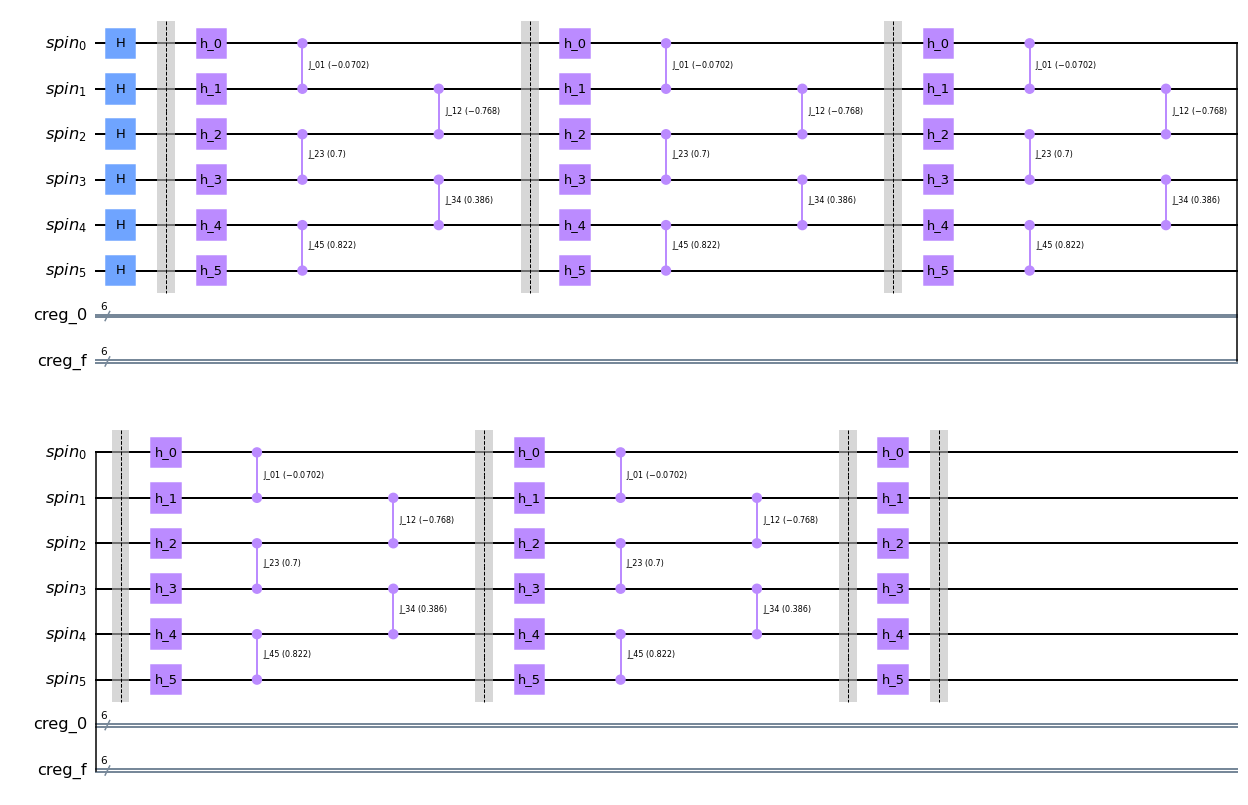

In [9]:
num_trotter_steps = 5
for step in range(num_trotter_steps):
    append_evolution(qc, h, J, gamma= np.random.random(), alpha= alpha, time= 0.8)
append_evolution(qc, h, J, gamma= 0.1, alpha= alpha, time= 0.8, is_terminal_step= True)
qc.draw("mpl")

In [8]:
# qc_i = qc.copy()
shots = 1000
qc.measure(spins, creg_final)
counts =  execute(qc, shots= shots, backend= qsm).result().get_counts() 

In [29]:
transits_exp = dict( [ (item[0].split(' ')[0], item[1]/shots ) for item in counts.items() ] )
transits_bltz = dict( [ ( state, model.get_boltzmann_prob(state) ) for state in transits_exp.keys() ] )

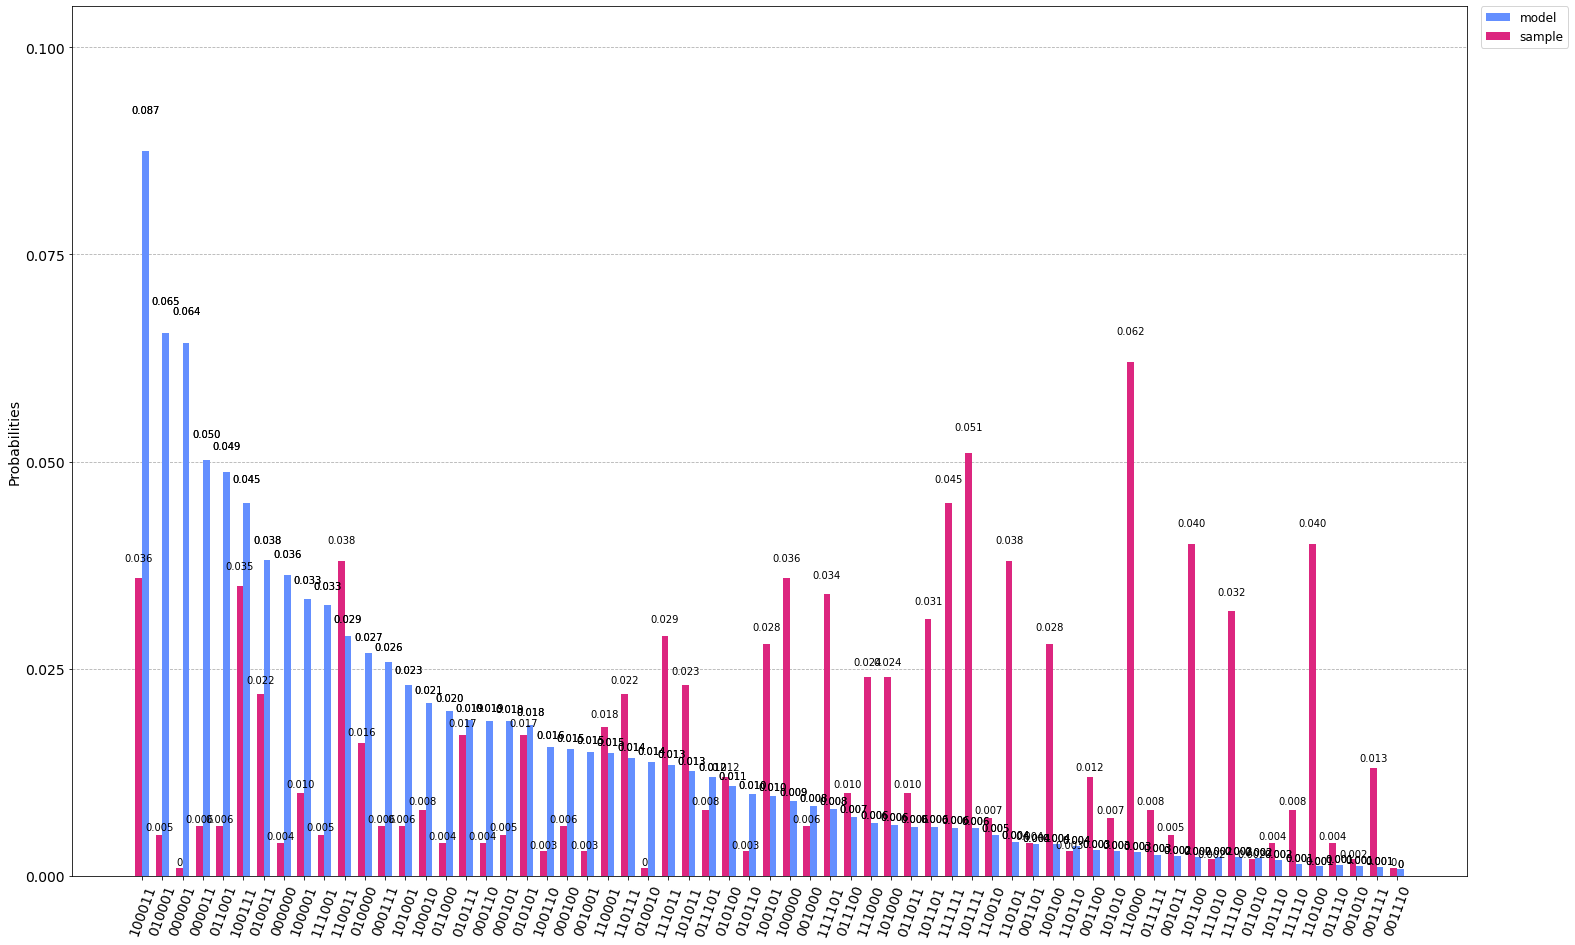

In [30]:
plot_histogram( [transits_bltz, transits_exp ] , figsize=(25, 16), sort= 'value_desc', legend= ['model', 'sample' ])